## Important: to  view the maps of the notebook (section 3), please follow this link :
http://nbviewer.jupyter.org/github/dav1248/ada_perons/blob/master/project/mileston3.ipynb

# ADA Project : Milestone 3 Notebook

In this notebook, we will introduce you to the dataset that we chose by locally importing a part of in, and store it in a dataframe. Hence, we will be able to have an insight on the work that we will perform on the full dataset.

In [ ]:
import json
import re
import numpy as np
import pandas as pd
from datetime import date, timedelta
import requests
from bs4 import BeautifulSoup
from dateutil.parser import parse
import csv
import folium
from pyspark.sql import *
from pyspark import SparkContext, SQLContext
%matplotlib inline

## 1. Twitter dataset data collection, from cluster to dataframe

In this section, we will make some operation with the help of Spark, to access, filter and export the useful tweets from the cluster to our computer.

### A few words about what we noticed for our dataset 

First, the twitter dataset starts from year 2012.
In the date section, the hour has been scaled, so that the tweet time is always relative to GMT+00. This will be of use when we will relate tweet dates and times with the Wikipedia dataframe.

### 1.1 Filtering the useful tweets

We start by declaring the Spark Context in order to make the link with the cluster. With Spark installed locally, we are able to query the cluster directly in the notebook.

In [8]:
sc = SparkContext()

In [9]:
text_file = sc.textFile("hdfs:///datasets/tweets-leon")

The idea of our filter is that we want to work with data that is already highly focused on our subject : terrorist  attacks. For the Milestone 2, we implemented a filter that considered different languages. Following the feedback from the TAs, we decided to stick with only English as the language of the tweets and the keywords, to go back to a **more simple, but more precise filter**. When a tweet is passed through the filter, we will compute the tweet score depending on its content and, if the score is high enough, select the tweet to be part of our dataframe. 

**We define below a few helper functions that will be used for our inition filter :** 



This function is the heart of the filter. Five lists are detailed, representing words of different importance. 

In [10]:
def words_to_match():
    

    language = 'en'
    
    t1 = ['terror attack', 'terrorist attack','suicide bombing','mass shooting']



    t2 = ['suicide bomber','car bombing','drone bombing','mass execution','improvised explosive device','truck bomb','grenade attack','train bombing']


    t3 = [' ied', 'hijacking','genocide','bomb attack','vehicule attack','assasination','terrorism','weapon','knife','assault rifle','dead','deaths','died','injured','kill','plant','drive-by shooting','hostage','execution']


    hashtag = ['#prayfor','#terrorism','#terrorists','#terrorattack']

    malus_list = ['years ago','year ago', 'months ago','month ago','anniversary']
    
    l = [t1,t2,t3,hashtag,malus_list]
    
    return l

The below function computes the importance of a tweet by assigning specific weights to every tweet. The assignment is done by iterating on all interesting words, looking whether they occur in the tweet content. According to the word's affiliation to one of the lists, different weight are incremented. If the total weight of the tweet reaches the threshold value (here 1.0), the filter returns True.

In [11]:
def is_interesting(content,l):
    
    content = content.lower()
    
    lang = content[:2]
    
    
    weight=0.0
    
    
    
    for w in l[0]:
        if w in content:
            weight+=1.0

    for w in l[1]:
        if w in content:
            weight+=0.9

    for w in l[2]:
        if w in content:
            weight+=0.1
             
    for w in l[3]:
        if w in content:
            weight+=0.7
            
            
    for w in l[3]:
        if w in content:
            weight-=0.5
    
    return (weight >= 1)
    

We declare the variable `bds` to be the three filtering dictionnaries. It will serve as an input of our filtering function.

In [12]:
bds = words_to_match()

Next, we actually call spark by filtering the data in the cluster with our filter, to then take a subset of defined size. We proceed to write it to a text file for later use.

In [13]:
terrorism = text_file.filter(lambda t: is_interesting(t,bds)).take(10)

In [14]:
file_t = open('tweets_terror3.txt','w')
for item in terrorism:
    file_t.write("%s\n" % item)

In [15]:
terrorism[:5]

['en\t345965752198762497\tSat Jun 15 18:07:17 +0000 2013\tSangyeH\tRT @AnnieSage: Unbelievable.... @thinkprogress: In the 6 months since Newtown, there have been FOURTEEN mass shootings http://t.co/yfClLGdx…',
 'en\t345965794213117952\tSat Jun 15 18:07:27 +0000 2013\tSR_Brant\tRT @AnnieSage: Unbelievable.... @thinkprogress: In the 6 months since Newtown, there have been FOURTEEN mass shootings http://t.co/yfClLGdx…',
 'en\t345968344391884800\tSat Jun 15 18:17:35 +0000 2013\tkiraababee\tRT @SweaterGawd: I cum faster than the fbi during a terrorist attack - 😳 shoulda kept that to yourself homie',
 'en\t345968730020384768\tSat Jun 15 18:19:07 +0000 2013\tdrgauravn85\t@asma_rehman02 even your feeder USA is agreed your role in terrorist attacks',
 'en\t345969984171823104\tSat Jun 15 18:24:06 +0000 2013\tWatchTVChannels\tQuetta Carnage: 23 killed in terrorist attacks http://t.co/CZm3wp7kki http://t.co/FLreqkpteK']

### 1.2 Handling the filtered tweets

#### Some issues we encountered:

1)    Tweets can countain retweet so many times the same tweet can appear with a retweet identification: `RT @<username>`
    - Resolved by adding Frequency parameter for tweet that has been retweet 
    - Even tough we separeted the tweet from the retweet some of the tweets appears many time without the Retweet identification. It is still important to distinguish them and not count them many times since we reckon that simply copying a message or retweeting a message has less significance than creating it.
    
2)    Even if we remove the retweet, some tweets are still the same but have not the same length which can lead to count separetly the same tweet
    - Resolved by putting a fixed max length to all tweet
    - Or by testing if a string is in another (Complicated solution not adopted)

In [17]:
# Read the filtered tweets from the .txt files
tweets_raw = pd.read_csv(delimiter="\t",filepath_or_buffer='tweets_terr.txt', names=["lan","id","date", "user_name", "content"],encoding='utf-8',quoting=csv.QUOTE_NONE)

In [18]:
tweets_raw.head(5)

,lan,id,date,user_name,content
0,en,3.459658e+17,Sat Jun 15 18:07:17 +0000 2013,SangyeH,RT @AnnieSage: Unbelievable.... @thinkprogress...
1,en,3.459658e+17,Sat Jun 15 18:07:27 +0000 2013,SR_Brant,RT @AnnieSage: Unbelievable.... @thinkprogress...
2,en,3.459683e+17,Sat Jun 15 18:17:35 +0000 2013,kiraababee,RT @SweaterGawd: I cum faster than the fbi dur...
3,en,3.459687e+17,Sat Jun 15 18:19:07 +0000 2013,drgauravn85,@asma_rehman02 even your feeder USA is agreed ...
4,en,3.459700e+17,Sat Jun 15 18:24:06 +0000 2013,WatchTVChannels,Quetta Carnage: 23 killed in terrorist attacks...


In this project, the id and user name of the tweet is useless, we keep therefore only the language, the date and the content of the tweet.

In [19]:
tweets_raw = tweets_raw.drop(axis= 1, labels=  ["id", "user_name"])
tweets_raw = tweets_raw.dropna()

The date countained in the tweets has been translated into `GMT` 0. So we do not have to worry about translating the date and can directly standarize with the dateutil.parser

In [20]:
#We parse the date to have a uniform 
tweets_raw["date"] = tweets_raw["date"].apply(lambda d: parse(d, ignoretz = True))

In [21]:
tweets = tweets_raw.copy()
tweets["retweet"] =  tweets["content"].map(lambda s : s[0:4] == "RT @") #Is it a retweet?

Here, we need to normalize our tweet to handle 1) and 2)

In [22]:
def remove_http(t):
    content = t.split()
    for w in content:
        
        if "http" in w:
            content.remove(w)
    return " ".join(content)



# Maximum length that we allowed to have in oder to not have different tweet

MAX_LEN = 140 - 15 - 10  # Limit of a tweet minus the maximum user name 
                         # and other charachter added when a retweet is created


def remove_retweet_and_cut(t):
    """
    Function that remove the RT @ in front of a tweet if it has been detected as a retweet, 
    And cut the tweet according to the MAX_LEN parameter
    """
    
    
    if(t["retweet"]): # We take advantage to uniform the tweets by the lower() function
        return ' '.join(t["content"].split()[2:])[0:MAX_LEN].lower()
    else :
        return t["content"][0:MAX_LEN].lower()
    

    
#Apply the functions we just created
tweets["content"] = tweets["content"].map(remove_http)
tweets["content"] =  tweets.apply(remove_retweet_and_cut, axis = 1)


#------------------------- Handling the frequency of a tweet ---------------------


# We create a dict to map the content and the frequency that a tweet with the same content occur.
freq_dict = dict(tweets.groupby("content")["lan"].count())


tweets = tweets.drop_duplicates(subset="content")


tweets["frequency"] = tweets["content"].map(lambda c : freq_dict[c])

We end up with a nice dataframe of the filtered tweets with the frequency of each tweets 

In [23]:
tweets.sort_values(by="frequency", ascending=False).head()

,lan,date,content,retweet,frequency
423016,en,2015-01-12 00:36:17,"2,000 civilians killed in a terrorist attack i...",True,3006
352,en,2012-12-17 03:29:35,here they are - all sixty-one mass shootings i...,True,1585
361528,en,2014-12-17 20:14:55,"just heard about the terrorist attack, my hear...",True,1330
418277,en,2015-01-11 14:01:14,chanting &amp; applause in paris as huge crowd...,True,1242
256112,en,2013-09-25 17:17:29,"in 1962, the us government planned terrorist a...",True,1218


In [24]:
#Here are the single tweets
tweets.sort_values(by="frequency", ascending=True).head()

,lan,date,content,retweet,frequency
254900,en,2013-09-24 13:40:38,coming up. like bomb shelters here at home in ...,False,1
327762,en,2014-05-06 09:22:31,people should go home for failing to prevent t...,False,1
327763,en,2014-05-06 09:51:24,".@nikkiyanofsky, @un reports over 399 #priceta...",False,1
327764,en,2014-05-06 11:03:08,@gasam101 would have called for the help of co...,True,1
327765,en,2014-05-06 12:07:02,bombs planted near vaishali's polling station ...,False,1


We see below that the ratio of retweet is consequent. 
Indeed, roughly 1/3 of our filtered tweets have been retweeted.

In [25]:
tweets["retweet"].sum()/len(tweets.retweet)

0.30587482267211957

In [26]:
grp_tweet = tweets.groupby("lan")

In [27]:
grp_tweet["content"].count()

lan
de      1017
en    319924
es      1032
fr       693
it       842
nl      1455
Name: content, dtype: int64

We see that, not surprisingly, we have more english tweets than the other languages. Indeed english is the most common widespread language and spanish the second one.

In [28]:
tweets = tweets.drop(axis= 1, labels=  ["lan"])
tweets.to_csv("dataframe_terror.csv", index=False)

## 2. Data from Wikipedia

In this part we scrape data from Wikipedia. We want to access the tables that register the terror attacks that happened at some point in the past. There are some Wikipedia articles (such as https://en.wikipedia.org/wiki/List_of_terrorist_incidents_in_January-June_2011) that do exactly that. The data is presented as tables, and all the articles that we need present data in this form.

In [31]:
# Simple map of month name to its number
month_to_int = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Reversed map
int_to_month = {i: m for m, i in month_to_int.items()}

In [32]:
# The wikipedia URL that every article has in common
base_url = 'https://en.wikipedia.org/wiki/List_of_terrorist_incidents_in_'

We show all the articles that we are going to use to find the data

In [ ]:
# All specific end of the wikipedia URL, along with the corresponding month numbers of the article
times = {}

for year in range(2011, 2015):
    # For years 2011 to 2014, the articles appear biyearly
    times.update({'January-June_' + str(year): list(range(1, 7))})
    times.update({'July-December_' + str(year): list(range(7, 13))})
    
for year in range(2015, 2018):
    # For years 2015 to 2017, the articles appear monthly
    for month, int_ in month_to_int.items():
        times.update({month + '_' + str(year): [int_]})
        
list(times.keys())


In [34]:
def to_int(s):
    '''Returns the first integer found in s'''
    i = re.findall('\d+', s)
    return int(i[0]) if len(i) > 0 else float('NaN')

In [35]:
def to_date(s, year):
    '''Returns a date from the datetime library from a string like \'January 1\''''
    l = s.split(' ')
    return date(to_int(year), month_to_int[l[0]], to_int(l[1]))

In [36]:
def wiki_table_to_df(end_url, month_range, base_url=base_url):
    '''Creates a dataframe from the tables available in the wikipedia page'''
    print('Scraping for', end_url)
    r = requests.get(base_url + end_url) # Get request
    soup = BeautifulSoup(r.text, 'lxml') # Parse HTML
    wiki_tables = soup.findAll('table', {'class': 'wikitable sortable'}) # Get tables from the wikipedia page

    table = []

    for month_int, wiki_table in zip(month_range, wiki_tables):
        for row in wiki_table.findAll('tr'):
            elems = row.findAll('td') 
            if len(elems) != 0:
                interesting = [elem.text for elem in elems[:5]]
                 # First element is the day of the month, but we add the name of the month as well in front of it
                interesting[0] = int_to_month[month_int] + ' ' + interesting[0]
                table.append(interesting)
                
    df = pd.DataFrame(table, columns=['date', 'type', 'deaths', 'injuries', 'location'])
    df.date = df.date.apply(lambda s: to_date(s, end_url[-4:])) # Translate the date with the year defined by the end_url arg
    df.deaths = df.deaths.apply(to_int) # Map death number to int
    df.injuries = df.injuries.apply(to_int) # Map injuries number to int
    
    return df

In [ ]:
dfs = []

# Get a DataFrame for every article from 2011 to 2017
for time, month_range in times.items():
    dfs.append(wiki_table_to_df(time, month_range))
    
df = pd.concat(dfs)
print('We have {} registered attacks from January 1st, 2011 up to today (November 28th, 2017)'.format(df.shape[0]))

Here is what some of the entries of the final result look like

In [38]:
df.iloc[[0, 56, 1033, -1]]

,date,type,deaths,injuries,location
0,2011-01-01,Suicide bombing,21.0,97.0,"Alexandria, Egypt"
56,2011-02-13,Raid,7.0,5.0,"Zamboanga, Philippines"
37,2014-11-18,"Shooting, Melee attack",5.0,7.0,"Jerusalem, Israel"
48,2017-12-17,Suicide bombing,1.0,5.0,"Kandahar province, Afghanistan"


Finally, we want to separate the location into a city, and a country, if applicable. This separation will be very useful for the matching of the attacks with our tweet dataset. To do so, we define some helper function :

In [ ]:
# Words that we should not keep when parsing city names
useless_words_cities = [
    'near',
    'far',
    'across', 
    'outskirts of',
    'south of',
    'north of'
    'south',
    'north',
    'east',
    'west', 
    'various places in',
    'border crossing',
    'industrial zone',
    'region',
    'province',
    'district'
]

# Words that we should not keep when parsing country names
useless_words_countries = [
    ' and ',
    'northern',
    'southern',
    'eastern',
    'northwestern',
    'east',
    'across',
    'central',
    'northwest',
    'border region',
    'prospective'
]

def remove_useless(s):
    '''Removes useless words and list of names'''
    s = s.lower()
    for uw in useless_words_cities:
        s = s.replace(uw + ' ', '')
        s = s.replace(uw, '')
            
    if ' and ' in s:
        s = s.split(' and ')[0]
        
    if '/' in s:
        s = s.split('/')[0]
            
    return s.title()

def clean_country(country):
    '''Sets the country name to a norm'''
    if 'Nigeria' in country:
        country = 'Nigeria'                
    if 'Jerusalem' in country:
        country = 'Israel'        
    if 'West Bank' in country:
        country = 'Palestine'        
    if 'Congo' in country:
        country = 'Congo'        
    if 'Dagestan' in country:
        country = 'Russia'        
    if 'Abkhazia' in country:
        country = 'Russia'        
    if 'Balochistan' in country:
        country = 'Pakistan'        
    if 'Hebron' in country:
        country = 'Palestine'        
    if 'Burma' in country:
        country = 'Myanmar'        
    if 'Northern Ireland' in country:
        country = 'United Kingdom'
    
    country = clean_extremities(country)
        
    return country

def clean_extremities(s):
    '''Cleans both ends of a string by removing commas, points, etc.'''
    while len(s) > 0 and not s[0].isalpha():
        s = s[1:]
        
    while len(s) > 0 and not s[-1].isalpha():
        s = s[:-1]
        
    return s

def special_cases(location):
    '''Handles locations that do not have a comma in them'''
    location = location.lower()
    
    for uw in useless_words_countries:
        if uw + ' ' in location:
            location = location.replace(uw + ' ', '')
        if uw in location:
            location = location.replace(uw, '')
            
    if 'jerusalem' in location:
        location = 'Israel'
        
    if 'west bank' in location:
        location = 'Palestine'
            
    return 'Unknown', location.title()

def city_country_from_location(location):
    '''Gets the city and country name from a string that is looking like \'Paris, France\''''
    location = clean_extremities(location)
    
    # Really special cases that we have to treat by hand
    really_special = {
        'Zliten Libya': ('Zliten', 'Libya'),
        'Alau.Nigeria': ('Alau', 'Nigeria'),
        'Damascus Syria': ('Damascus', 'Syria'),
        'Kibirizi Democratic Republic of Congo': ('Kibirizi', 'Congo'),
        'Belfast Northern Ireland': ('Belfast', 'United Kingdom'),
        'Oberhausen Germany': ('Oberhausen', 'Germany'),
        'Lahj Governorate Yemen': ('Unknown', 'Yemen'),
        'El-Baraf Somalia': ('Unknown', 'Somalia'),
        'Baghdad Iraq': ('Baghdad', 'Iraq'),
        'Luqa Malta': ('Luqa', 'Malta'),
        'Muradiye Turkey': ('Muradiye', 'Turkey'),
        'Concepción Paraguay': ('Concepción', 'Paraguay'),
        'Deir Ez-Zor Syria': ('Deir Ez-Zor', 'Syria'),
        'Deir ez-Zor Syria': ('Deir Ez-Zor', 'Syria'),
        'Indian Ocean': ('Unknown', 'Indian Ocean'),
        'Qamishli Syria': ('Qamishli', 'Syria'),
        'Oignies, Pas-de-Calais': ('Oignies', 'France'),
        'Khost Province': ('Unknown', 'Afghanistan'),
        'Ratchaprasong Intersection, Bangkok': ('Bangkok', 'Thailand'),
        'Beit Hanun, Gaza Strip': ('Beit Hanun', 'Palestine'),
        'Crimea': ('Unknown', 'Russia'),
        'Moyen-Cavally, Côte d\'Ivoire': ('Moyen-Cavally', 'Ivory Coast'),
        'Lawdar, Lahij Yemen': ('Lawdar', 'Yemen'),
        'Atizapán de Zaragoza, México': ('Atizapán de Zaragoza', 'Mexico'),
        'Queens, New York': ('New York City', 'United States'),
        'Jonglei, Southern Sudan': ('Jonglei', 'South Sudan'),
        'Austin, Texas': ('Austin', 'United States'),
        'Karabudakhkent, Dagestan, Russian Federation': ('Karabudakhkent', 'Russia')
    }
    
    if location in really_special.keys():
        return really_special[location]
    
    if ',' in location:
        city = location.split(',')[0]
        country = location.split(',')[-1]
        
        city = clean_extremities(remove_useless(city))
        country = clean_country(country)
        
        if len(city) == 0:
            city = 'Unknown'
        
        return city, country
    else:
        return special_cases(location)

In [ ]:
cities_countries = df.location.map(city_country_from_location).apply(pd.Series)
# Applying the city names and country names in the dataframe
df['city'] = cities_countries[0]
df['country'] = cities_countries[1]

# Getting rid off the dataframe
df = df.drop('location', axis=1)

We now have a useful and clean dataset of all terrorist attacks listed on wikipedia. The next step will be to analyze this data first on its own, and then coupled with the twitter dataset that we defined before.

## 3. Making sense of the Data

In this section, we will detail our analysis in an attempt to answer to the fundamental questions of our project : which part of the world is more hit by terrorist events, and how can we compare the real impacts (deaths, injured) of such attacks with the reaction on the social media sphere (number of tweets, relevance on attacks).

As explained a few cells below next to the corresponding code, we will **focus on a time period between January 2011 and January 2016** (which is the timestamps of the oldest and most recent tweets in the database) for the rest of our analysis. The results, displays and analysis will therefore be related to this specific time period of **five years**. This period is according to us long enough to advance certain hypothesis, and it has also been marked by the rise and fall of many different terrorist groups that shaped a big part of the geopolitics of today.



### 3.1 Create new DataFrame with Tweets and Wiki data

The main task of this section is to make the link between a tweet and the terrorist attack it is related to.

In [6]:
# Import the df, if we don't have them stocked in the buffer
tweets = pd.read_csv("dataframe_terror.csv", parse_dates=[0])
terror = pd.read_csv('attacks.csv', parse_dates=[0], encoding="utf-8")
terror["type"] = terror["type"].fillna("UnkownType")

In [463]:
print("Number of tweets that we have (without counting duplicates): "+str(len(tweets)))
tweets.head()

Number of tweets that we have (without counting duplicates): 319682


,date,content,retweet,frequency
0,2013-06-15 18:07:17,unbelievable.... @thinkprogress: in the 6 mont...,True,2
1,2013-06-15 18:17:35,i cum faster than the fbi during a terrorist a...,True,1
2,2013-06-15 18:19:07,@asma_rehman02 even your feeder usa is agreed ...,False,1
3,2013-06-15 18:24:06,quetta carnage: 23 killed in terrorist attacks...,False,1
4,2013-06-15 18:36:29,quetta carnage: 23 killed in terrorist attacks,False,2


In [8]:
print(len(terror))
terror.head()

4703


,date,type,deaths,injuries,location,city,country
0,2011-01-01,Suicide bombing,21.0,97.0,"Alexandria, Egypt",Alexandria,Egypt
1,2011-01-04,Assassination,1.0,0.0,"Islamabad, Pakistan",Islamabad,Pakistan
2,2011-01-04,Bombing,4.0,26.0,"Abuja, Nigeria",Abuja,Nigeria
3,2011-01-07,Kidnapping,9.0,NaN,Niger,Unknown,Niger
4,2011-01-07,Suicide bombing,17.0,23.0,"Spin Boldak, Afghanistan",Spin Boldak,Afghanistan


In order to save computationnal ressources and to prevent missmatch, we start by filtering the the date. Indeed we will discard the tweets that happen before our first terrorist attck and all the attacks that happen after our last tweet.

In [10]:
min_date = max(tweets.date.min(), terror.date.min())
max_date = min(tweets.date.max(), terror.date.max())

tweets = tweets[(tweets["date"]>min_date) & (tweets["date"]<max_date )]
terror = terror[(terror["date"]>min_date) & (terror["date"]<max_date )]

print("tweets len = "+str(len(tweets)))
print("tweets len = "+str(len(terror)))

tweets len = 319682
tweets len = 1579


This part is the main part of our project, it covers the filter that we use to match a tweet with a terror attack.

In [328]:

def date_score(dtweet, dattack):
    """
    takes the data of the tweet and the attack and return 
    the score accordingly to how far they are to each other.
    """
    diff = (dtweet - dattack).days
    
    alpha = 0.55
    
    if diff < 0 :
        return -np.Inf
    
    else :
        if 0 <= diff and diff < 4:
            return 0.79
            
        return 0.79 / (alpha *(diff-4) + 1)

    
def match_filter(t, terror):
    """
    The matched filter takes one tweet the whole terrorist attack dataframe
    and return the most probable index of the attack that has a link with the tweet
    """
    
    
    overall_score = 0
    overall_index = -1
    
    # The sliding time widow (STW)
    stw = timedelta(30)
    
    # We won't worry the case where the attack date is greater than the date of the tweet and apply the STW
    sub_terror = terror[(terror["date"]<t["date"]) & (terror["date"]>t["date"]-stw) ]
    
    content = t["content"].split()
    
    # List related to death:
    death_sem = ["die", "death", "dead", "kill"]
                       
    # List related to injured
    injured_sem = ["injure", "hurt", "wound", "harm", "damage"]
    
    # List of attacks that can easily be missclassified from 
    # a terrorist attack (reduce the type score see bellow)
    common_attack = ["attack", "attacks", "shooting", "bombing", "bombs", "shootings", "bomb" ]
    
    
    # List of malus words that doesn't fit in the context of a terrorist attack
    malus_word = ["great", " happy", " friend"]
    
    # Check here if the tweet contains a penalty word
    malus = False
    # Malus word 
    for w in malus_word:
        if w in t["content"]:
            
            malus = True
            break
    
    #For ecach event we will compute the hypothetic score matching relating to a particular attack
    for index, attack in zip(sub_terror.index,sub_terror.get_values()):


        # extracting the attack parameters
        dattack, type_attack, death, injured, _ ,city, country = attack
        
        #
        score = date_score(t["date"], dattack )
        sda = score
                       
        #If the tweet countains the exact number of death we already consider as acceptable
        if(not np.isnan(death)):
            if(str(int(death)) in content) or (str(int(death-1)) in content): #We also consider death - 1 in case the killer killed himself wikipedia count every killed whereas the tweets basically don't count it        
                #print("Yo")
                for w in death_sem:
                    #print(w)
                    if w in t["content"]:
                        
                        sde=0.24 * len(str(int(death-1)))
                        
                        #It's very easy to match number with one digit, less with 2 ... ect so:
                        score +=0.24 * len(str(int(death)))
    

        #If the tweet countains the exact number of injured we already consider as acceptable
        if(not np.isnan(injured)):
            if((str(int(injured)) in content)):
                
                for w in injured_sem:
                    if w in t["content"]:
                        
                        si=0.24 * len(str(int(injured))) 
                        score +=0.24 * len(str(int(injured))) 
                        #print("injured score = "+str(0.45 * len(str(int(injured)))))

        #If the tweet countains the city of the attack we already consider as acceptable

        if(city.lower() in t["content"]):
            score += 0.8
            sci = 0.8
            #print("city score = "+str(0.7))
            
        #If the tweet countains the country of the attack we don't consider as acceptable,
        #but we increase the score
        if(country.lower() in t["content"]):
            score += 0.6
            sco = 0.6
            #print("country score = "+str(0.5))

        
        if(type_attack.lower() in t["content"] ):
            
            in_ = False
            
            for w in common_attack:
                
                if (type_attack.lower() in w):
                    in_ = True
                    st += 0.1
                    score += 0.1
                    #print("attack score = "+str(0.1))
                    break
            
            if(not in_):
                st += 0.5
                score += 0.5

                
        # Handling the malus word here 
        # It could be done before entering in the attack loop but shouldn't take that much time here
        if(malus):
            score -=0.3
        
        
        # Now we check if the previous best score is lower than the current one
        if(overall_score < score):
            overall_score = score
            overall_index = index
    
    # Check if we have to reject the tweet
    if(overall_score <1 ):
        return -1
    
    else:
        return overall_index

In [468]:
def compare_(nb_tweet, nb_terr):

    print("Content :"+ tweets.loc[nb_tweet]["content"])
    print("-------------------Tweet metadata--------------------")
    print(tweets.loc[nb_tweet])
    print("-------------------Attack metadata--------------------")
    print(terror.loc[nb_terr])


In [329]:
tu = tweets.copy()
%time tu["related_attack"] = tu.apply(lambda t: match_filter(t, terror) , axis = 1)

CPU times: user 27min 35s, sys: 12.1 s, total: 27min 47s
Wall time: 28min 5s


Investingating the improvement of the sliding time window (Parameter stw in `def match_filter`) 

In [470]:
print("Sliding time window: 5 days ->  0.7691154422788605% of drop on 2000 Tweeets in 4.89 s")
print("Sliding time window: 15 days -> 0.7391304347826086% of drop on 2000 Tweeets in 6.07 s")
print("Sliding time window: 30 days -> 0.7336331834082959% of drop on 2000 Tweeets in 8.56 s")
print("Sliding time window: 60 days -> 0.7206396801599201% of drop on 2000 Tweeets in 13.8 s s")
print("Sliding time window: 90 days -> 0.7141429285357321% of drop on 2000 Tweeets in 17.8 s")
print("Sliding time window: 120 days-> 0.7116441779110445% of drop on 2000 Tweeets in 22.9 s")
print("Sliding time window: 400 days-> 0.6966516741629185% of drop on 2000 Tweeets in 70 s")

Sliding time window: 5 days ->  0.7691154422788605% of drop on 2000 Tweeets in 4.89 s
Sliding time window: 15 days -> 0.7391304347826086% of drop on 2000 Tweeets in 6.07 s
Sliding time window: 30 days -> 0.7336331834082959% of drop on 2000 Tweeets in 8.56 s
Sliding time window: 60 days -> 0.7206396801599201% of drop on 2000 Tweeets in 13.8 s s
Sliding time window: 90 days -> 0.7141429285357321% of drop on 2000 Tweeets in 17.8 s
Sliding time window: 120 days-> 0.7116441779110445% of drop on 2000 Tweeets in 22.9 s
Sliding time window: 400 days-> 0.6966516741629185% of drop on 2000 Tweeets in 70 s


Bellow are some selected tweets with the new field `related_attack`

In [504]:
tu.loc[[2,305690, 45433,210933,130000, 300013]]

,date,content,retweet,frequency,related_attack
2,2013-06-15 18:19:07,@asma_rehman02 even your feeder usa is agreed ...,False,1,-1
305690,2015-11-20 16:14:17,.@lennykravitz has spoken of the city he calls...,True,1,1390
45433,2012-08-12 23:20:23,congratulations to those who successfully pred...,False,1,-1
210933,2014-06-28 07:00:02,"suicide bomber kills security officer, wounds ...",False,1,993
130000,2011-03-14 08:34:09,suicide bomber kills 10 soldiers at iraq army ...,False,8,108
300013,2015-11-14 19:13:22,why hasn't anyone mentioned that other terrori...,True,1,-1


We can see bellow that for this particular tweet, it has indeed match the related terror attack correctfully.

In [503]:
compare_(305690, 1390)

Content :.@lennykravitz has spoken of the city he calls home, paris, and the recent terrorist attacks that occurred there:
-------------------Tweet metadata--------------------
date                                       2015-11-20 16:14:17
content      .@lennykravitz has spoken of the city he calls...
retweet                                                   True
frequency                                                    1
Name: 305690, dtype: object
-------------------Attack metadata--------------------
date        2015-11-13 00:00:00
type                     Attack
deaths                      130
injuries                    368
location          Paris, France
city                      Paris
country                  France
Name: 1390, dtype: object


And for this one correctfully didn't match to any terror attack

In [506]:
tu.loc[45433]["content"]

'congratulations to those who successfully predicted some sort of terrorist attack. nostradamus would be proud.'

In [473]:
print("Percentage of the tweets drop by our matched filter: "+str(len(tu[tu['related_attack']==-1])/len(tu))+"%")

Percentage of the tweets drop by our matched filter: 0.6710355916191716%


In [582]:
def expand_with_attacks(terror, index):
    """
    This function is used to expand the tweets df according to the related attack field.
    """
    
    attack = terror.loc[index]
    
    return attack["city"], attack["country"], attack["deaths"], attack["injuries"] , attack["type"]
    


tweet_terr = tu.copy()

# cleanning the ones which isn't related to one particular attack
tweet_terr = tweet_terr[tweet_terr["related_attack"]!= -1]

#performing the map on the related_attack field to expand
terr_features = tweet_terr["related_attack"].map(lambda index : expand_with_attacks(terror, index) ).apply(pd.Series)


# Extracting the information on the df
tweet_terr['city'] = terr_features[0]
tweet_terr['country'] = terr_features[1]
tweet_terr['deaths'] = terr_features[2]
tweet_terr['injuries'] = terr_features[3]
tweet_terr['type'] = terr_features[4]

Here is what we finally have the final dataset which contains all the information that can countain a matched tweet with an attack.

In [508]:
tweet_terr.head()

,date,content,retweet,frequency,related_attack,city,country,deaths,injuries,type
7,2013-06-15 18:41:28,there was a huge terror attack in pakistan tod...,True,1,680,Unknown,Pakistan,27.0,21.0,"Bombings, shootings"
9,2013-06-15 18:44:41,a few days ago afghanistan had terror attacks ...,False,1,676,Kabul,Afghanistan,17.0,40.0,Suicide car bombings
12,2013-06-15 18:59:54,slave: \nsuicide bombers how are you fighting ...,False,2,673,Ah,Afghanistan,1.0,3.0,Bombing
22,2012-10-13 23:27:58,#baghdad suicide bomber kills at least 7 in ba...,False,1,520,Baghdad,Iraq,8.0,31.0,Suicide bombing
43,2012-05-21 22:42:51,suicide bombing kills scores of western-backed...,False,1,440,Sana'A,Yemen,120.0,350.0,Suicide bombing


In [509]:
# What we have for tweet #43 for example
compare_(43, 440)

Content :suicide bombing kills scores of western-backed yemeni soldiers dylan stableford, the lookout/y!news #al-qaida #sabe
-------------------Tweet metadata--------------------
date                                       2012-05-21 22:42:51
content      suicide bombing kills scores of western-backed...
retweet                                                  False
frequency                                                    1
Name: 43, dtype: object
-------------------Attack metadata--------------------
date        2012-05-21 00:00:00
type            Suicide bombing
deaths                      120
injuries                    350
location          Sana'a, Yemen
city                     Sana'A
country                   Yemen
Name: 440, dtype: object


### 3.1.2 Visual results using the matched dataframe

In [518]:
# saving the dataframe in .csv in order to not reload it
tweet_terr.to_csv("matched_df.csv", encoding="utf-8", index=False)

Bellow, we compute the tweets per death ratio in a particular country.

In [588]:
nb_tweet_country = tweet_terr.groupby("country").sum(skipna = True)["frequency"].sort_values(ascending = False)
nb_death_county =   terror.groupby("country").sum(skipna = True)["deaths"].sort_values(ascending = False)

In [599]:
ratio = nb_tweet_country / nb_death_county
ratio = ratio[(ratio != np.inf)]
ratio = ratio.dropna()
top_ratio = ratio.sort_values(ascending=False)[:8]
top_ratio

country
Denmark           1427.000000
Australia          682.666667
United States      428.024390
United Kingdom     385.000000
France             290.805195
Bulgaria           217.000000
Indonesia           81.714286
Israel              80.395833
dtype: float64

In [600]:
print(ratio.loc["France"] )
print(ratio.loc["Nigeria"])

top_ratio = top_ratio.to_frame()
top_ratio.columns = ['ratio']

290.805194805
2.53943925234


France has an average of 290 tweets for one dead whereas Nigeria has only 2.5 tweets per dead

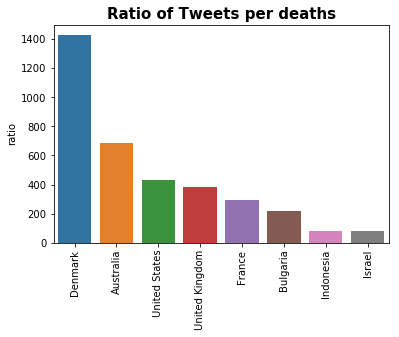

In [601]:
bar_plot(top_ratio, "Ratio of Tweets per deaths","ratio",rotation=90, sort=True, ascending=False)

In [448]:
top10_t = nb_tweet_city[:10]

m = pd.merge(top10_t.to_frame().reset_index(), nb_death_city.to_frame().reset_index(), on="city")
top10_d = m["deaths"][:10]


In [449]:
sns.barplot?

[]

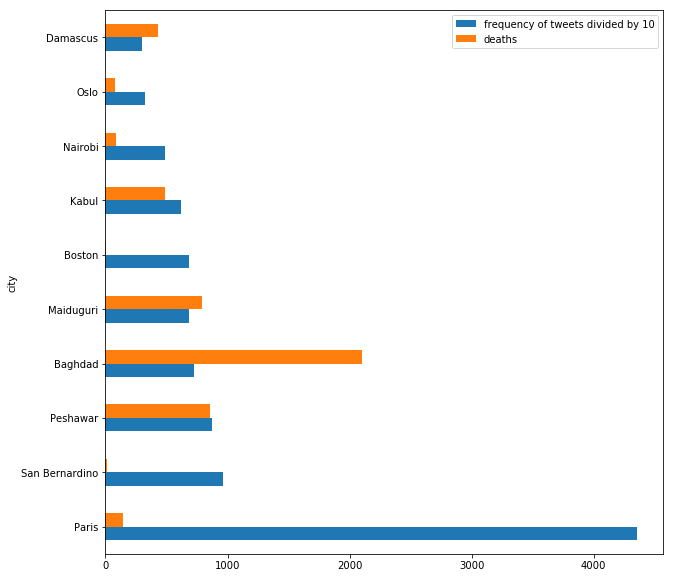

In [451]:
import matplotlib.pyplot as plt
import seaborn as sns

m["frequency of tweets divided by 10"] = m["frequency"].map(lambda x: x/10)

x = range(10)
 
#fig, ax = plt.subplots(figsize = (15,8))
#sns.barplot(x=m.city, y=m.frequency, ax=ax, color='#00aced', alpha = 0.5, label = "tweets")
#ax2 = ax.twinx()
#sns.barplot(x=m.city, y=m.deaths, ax=ax2, color='#ff0000', alpha =0.5)
#ax.bar(x, -top10_d, width=1, color='r')

m.plot.barh(x='city', y=["frequency of tweets divided by 10",'deaths'], figsize=(10,10))
plt.plot()

From the graph above, we clearly see the unbalanced ratio between the reaction and the real impact over cities. 

### 3.2 Plot the attacks in a map

In [11]:
# Mapping the names we had from Wikipedia to the name in the .geojson file
map_ = {
    'Bahamas': 'Bahamas, The',
    'Congo': 'Congo, Dem. Rep.',
    'Egypt': 'Egypt, Arab Rep.',
    'Iran': 'Iran, Islamic Rep.',
    'Ivory Coast': 'Côte d\'Ivoire',
    'Kyrgyzstan': 'Kyrgyz Republic',
    'Laos': 'Lao PDR',
    'Palestine': 'Palestine (West Bank and Gaza)',
    'Republic of Ireland': 'Ireland',
    'Republic of Macedonia': 'Macedonia, FYR',
    'Russia': 'Russian Federation',
    'South Korea': 'Korea, Rep.',
    'Syria': 'Syrian Arab Republic',
    'United States': 'United States of America',
    'Venezuela': 'Venezuela, RB',
    'Yemen': 'Yemen, Rep.',
    'Indian Ocean': 'Indian Ocean Territories'
}

In [12]:
# WARNING: both are not used anymore since we draw circles

def map_number_color(number):
    '''Maps the number we are interested in to a color'''
    number = np.sqrt(number)
    max_ = np.sqrt(attacks_per_country.number.max())
    min_ = np.sqrt(attacks_per_country.number.min())
    c = int(202 - (number - min_) / (max_ - min_) * 202)
    s = hex(c)[-2:]
    if c < 16:
        s = str(0) + hex(c)[-1]
    return '#' + hex(236)[-2:] + s + '00'

def color(name):
    '''Gets the color for a country'''
    if name in list(attacks_per_country.country):
        return map_number_color(attacks_per_country[attacks_per_country.country == name]['number'].values[0])
    else:
        return '#aeae9e' 

In [13]:
# folium.GeoJson(
#     geojson_world,
#     style_function=lambda feature: {
#             'fillColor': color(feature['properties']['name_sort']),
#             'color': '#151515',
#             'fillOpacity': 0.5,
#             'weight': 1
#     }
# ).add_to(world)

In [14]:
def radius(data, country):
    '''Gets the radius of the circle for a country'''
    max_ = np.sqrt(data.number.max())
    v = data[data.country == country].number.values
    if len(v) == 0:
        return 0
    return int(1000000 * int(np.sqrt(v[0])) / max_)

In [15]:
def number(data, country, measure):
    '''Gets the number we are interested in for a country'''
    v = data[data.country == country].number.values
    if len(v) == 0:
        return str(0)
    if ('\'' in country):
        country = country.replace('\'', '')
    return country + ': ' + str(int(v[0])) + ' ' + measure 

In [16]:
def build_map(data, measure, color):
    '''Builds a map from the data. The data is expected to have a \'country\' column and a \'number\' column'''
    geojson_world = json.load(open('custom.geo.json', encoding='utf-8')) # JSON file containing the border
    lat_lon_json = json.load(open('clean.json')) # JSON file containing the latitude and longitude of each country
    
    # Creating the map
    world = folium.Map([30, 5], tiles='cartodbpositron', zoom_start=2)
    
    # Adding a circle for each country. The circle is clickable to see the number
    for country in lat_lon_json:
        folium.Circle(
            location=[float(country['lat']), float(country['lon'])],
            radius=radius(data, country['name']), # The size depends on the number
            fill=True,
            fill_color=color,
          # fill_color=my_color_function(country['name']),
            fill_opacity=0.2,
            opacity=0,
            popup=folium.Popup(number(data, country['name'], measure)), # The texts also depends on the number
            control=False
        ).add_to(world)
        
    return world

In [18]:
# Getting the mixed data
matched = pd.read_csv('matched_df.csv', encoding='utf-8')

# The reaction is the sum of tweets and retweets for each country
reaction_per_country = matched.groupby(by='country', as_index=False).sum()[['country', 'frequency']]
reaction_per_country = reaction_per_country.rename(columns={'frequency':'number'})

reaction_per_country.country = reaction_per_country.country.map(lambda c: map_[c] if c in map_.keys() else c)

In [19]:
# Getting the wiki data
df = pd.read_csv('attacks.csv', encoding='utf-8', parse_dates=[0])
print('We have {} registered attacks from January 1st, 2011 to January 31st, 2016'.format(df[df.date < date(2016, 1, 31)].shape[0]))

# Grouping by country, summing for the number of deaths
attacks_per_country = df[df.date < date(2016, 1, 31)].groupby(by=['country'], as_index=False).count()[['country', 'date']]
attacks_per_country = pd.DataFrame(attacks_per_country.sort_values(by=['country'])).rename(columns={'date': 'number'})

# Changing the names to what we want
attacks_per_country.country = attacks_per_country.country.map(lambda c: map_[c] if c in map_.keys() else c)

We have 1574 registered attacks from January 1st, 2011 to January 31st, 2016


In [22]:
attacks = build_map(attacks_per_country, 'attacks', '#ff0000')

In [23]:
attacks

In [24]:
attacks.save('attacks_2011_2016.html')

In [25]:
reaction = build_map(reaction_per_country, 'tweets', '#00aced')
reaction

In [26]:
reaction.save('reaction_2011_2016.html')

### 3.3 Other graphs/info

#### 3.3.2 Safety ranking

In [566]:
import matplotlib.pyplot as plt
import seaborn as sns
    
def bar_plot(data, title, y, x='', rotation=0, sort=False, ascending=True):
    '''Just to do a simple barplot'''
    fig, ax = plt.subplots()
    ax.set_title(title, fontsize=15, fontweight='bold')
    if sort:
        ax = sns.barplot(data.sort_values([y], ascending=ascending)[y].keys(), data.sort_values([y], ascending=ascending)[y], ax=ax)
    else:
        ax = sns.barplot(data[y].keys(), data[y], ax=ax)
    locs, labels = plt.xticks()
    ax.set(xlabel=x, ylabel=y)
    plt.setp(labels, rotation=rotation)
    plt.show()

We will now perform a ranking of the most unsafe cities and countries. By doing so, we hope to highlight the parts of the world where terrorism can be an everyday worry.

**We will now classify every city according to their number of terror attacks, and casualties :**

To do so, we will create a DataFrame containing cities and their respective rankings by number of events, and casualties.

In [72]:
most_dangerous_cities = terror.groupby('city')['city'].count().sort_values(ascending=False)
most_dangerous_cities2 = terror.groupby('city').sum()['deaths'].dropna().sort_values(ascending=False)

cities = most_dangerous_cities.to_frame()
cities.columns = ['events']
cities['rank_event'] = range(1,len(cities.index)+1)
cities = cities.reset_index()
cities2 = most_dangerous_cities2.to_frame()
cities2.columns = ['casualties']
cities2['rank_casualties'] = range(1,len(cities2.index)+1)
cities2 = cities2.reset_index()
mg = cities.merge(cities2, on='city').iloc[:20] # We select the cities that are the most affected
mg = mg.set_index('city')
mg = mg.drop('Unknown') # drop the events with no city in the wikipedia database
mg

# attention iraq != across iraq

,events,rank_event,casualties,rank_casualties
city,,,,
Baghdad,100,1,1613.0,3
Kabul,48,3,406.0,10
Peshawar,38,4,860.0,4
Mogadishu,38,5,417.0,9
Maiduguri,25,6,789.0,5
Karachi,20,7,322.0,13
Damascus,18,8,429.0,8
Quetta,17,9,341.0,11
North Waziristan,15,10,153.0,27


As a result, **Baghdad** the most dangerous place on earth in terms of number of terror attacks, and second in terms of casualties. With 100 attacks during the studied period, it is more than three times more than the second most hit city, Kabul.

Our study period goes from January 2011 to January 2016, which makes it around **one attack every two weeks**.

Even though Baghdad has been covered by the Western Media during the Iraqi war with the intervention of the USA, one might be surprised by the other members of the most hit cities, such as Maiduguri, Quetta, Peshawar.

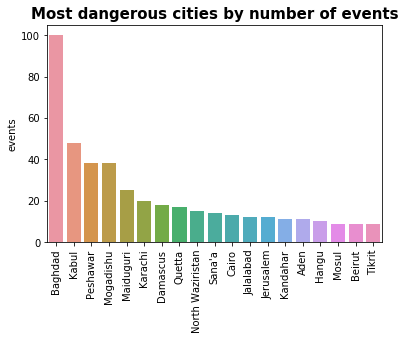

In [73]:
bar_plot(mg,'Most dangerous cities by number of events', 'events', rotation=90, sort=True, ascending=False)

**The number of events is for sure significant, but to complete our viewpoint, we will plot the same ranking by number of casualties :**

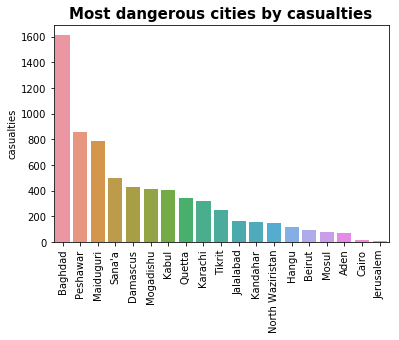

In [74]:
bar_plot(mg,'Most dangerous cities by casualties', 'casualties', rotation=90, sort=True, ascending=False)

Baghdad registered 100 events, for a death toll of 1613 : an attack makes on average more than 16 victims, a sad finding of the every-day reality that happens far-away from our safe houses !

In [75]:
most_dangerous_countries = terror.groupby('country')['country'].count().sort_values(ascending=False)
most_dangerous_countries2 = terror.groupby('country').sum()['deaths'].dropna().sort_values(ascending=False)

countries = most_dangerous_countries.to_frame()
countries.columns = ['events']
countries['rank_event'] = range(1,len(countries.index)+1)
countries = countries.reset_index()
countries2 = most_dangerous_countries2.to_frame()
countries2.columns = ['casualties']
countries2['rank_casualties'] = range(1,len(countries2.index)+1)
countries2 = countries2.reset_index()
mgc = countries.merge(countries2, on='country') # We select the cities that are the most affected
mgc = mgc.set_index('country')

Iraq tops the list, and to illustrate the gap between the first few countries and the others, we will now introduce our final plot for this section, the rank by percentage of casualties :

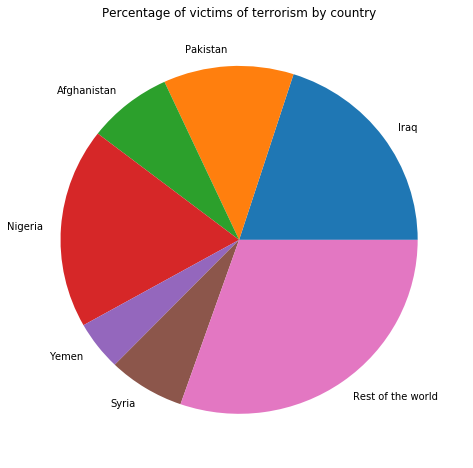

In [76]:
total_cas = mgc['casualties'].sum()
mgc['per_casualties']=mgc['casualties'].map(lambda x: 100*x/total_cas)

s = mgc.iloc[:6]['per_casualties'].sum()
others = 100-s
percentage = mgc['per_casualties'].iloc[:6].append(pd.Series({'Rest of the world':others}))
percentage.rename("").plot.pie(figsize=(8,8), title='Percentage of victims of terrorism by country')
plt.show()

In this astonishing ranking, we can highlight two important facts :

- The first **6 countries** of the list gather **more than *80%** of all deaths by terror attacks, and the other 30% are shared between all the other (around 200) countries.  
- The first European country in the list is France in 33th position. We can already imagine, before analyzing the social impact of those attacks, that this country has seen a much bigger social impact on the reactions to attacks, than most of the first 30 most hit countries.

### 3.3.2 Distribution of major groups

Lastly, we detail the most important active terrorist groups, but this time during the period of January 2011 to  December 2017. Indeed, there has unfortunately been a lot of activities of groups like ISIS during this larger timespan.

In [15]:
list_of_interest_groups = ['Islamic State','Boko Haram', 'Al Shabaab', 'Al Quaeda', 'ISIL', ]

In [16]:
import re

def norm_interest(w):
    
    w = str(w).lower()
    w = re.sub(r'-', ' ', w)  
    w = re.sub(r'\sin\s(.*)','',w)
    
    #special case
    w = re.sub(r'shabab', 'shabaab', w)  


    
    for l in list_of_interest_groups:
        if l.lower() in w:
            return l
    
    return w

In [27]:
terror_perp = df_perp.copy()
terror_perp['perpetrator'] = terror_perp['perpetrator'].map(norm_interest)
terror_perp.head(3)

,date,type,deaths,injuries,location,perpetrator
0,2016-02-01,Suicide bombing,20.0,29.0,"Kabul, Afghanistan",taliban
1,2016-02-01,Bombing,7.0,5.0,"Hīt, Iraq",Islamic State
2,2016-02-01,beheading,3.0,0.0,"Manbij, Syria",Islamic State


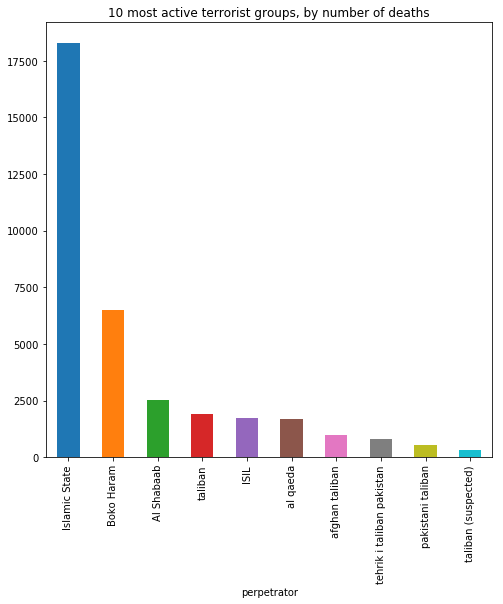

In [47]:
a = terror_perp.groupby('perpetrator')['deaths'].sum().drop('unknown').drop('').sort_values(ascending=False)
a.iloc[:10].plot.bar(figsize=(8,8), title='10 most active terrorist groups, by number of deaths')
plt.show()

With this graph, we can discover the dramatic impact of the activities of the Islamic State during the time period. On a more brighter note, the group is today on the verge of defeat, and we can just hope that no other terrorist group or other entity will ever inflict such pain to thousand of innocent victims !